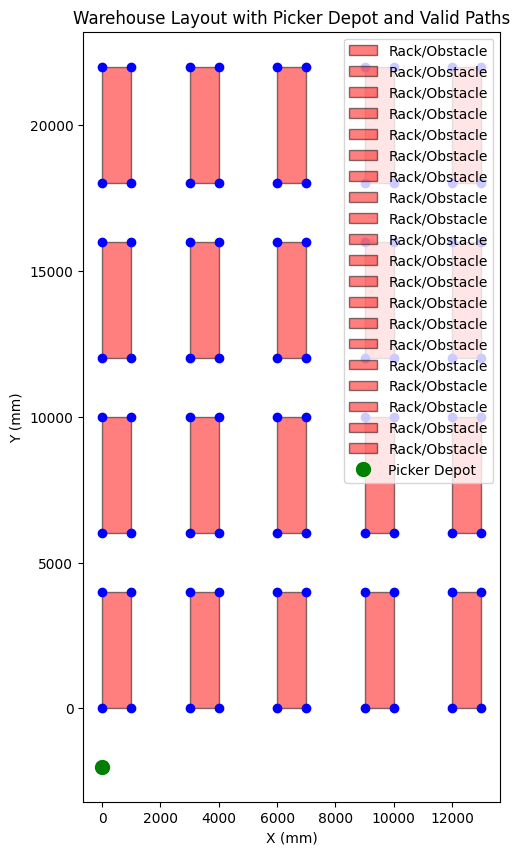

In [1]:
import numpy as np
from shapely.geometry import Polygon, LineString
import matplotlib.pyplot as plt


def generate_racks(rows, cols, rack_width=1000, rack_height=4000, walkway_width=2000):
    """
    Generates rack polygons and vertices for a traditional warehouse layout.
    :param rows: Number of rows of racks
    :param cols: Number of columns of racks
    :param rack_width: Width of each rack in mm
    :param rack_height: Height of each rack in mm
    :param walkway_width: Width of walkways between racks in mm
    :return: (list of rack polygons, list of vertices)
    """
    rack_polygons = []
    vertices = []

    for row in range(rows):
        for col in range(cols):
            # Bottom-left corner of the rack
            x_start = col * (rack_width + walkway_width)
            y_start = row * (rack_height + walkway_width)

            # Create a polygon for the rack
            rack_polygon = Polygon([
                (x_start, y_start),  # Bottom-left
                (x_start, y_start + rack_height),  # Top-left
                (x_start + rack_width, y_start + rack_height),  # Top-right
                (x_start + rack_width, y_start)  # Bottom-right
            ])
            rack_polygons.append(rack_polygon)

            # Add vertices (corners of the rack)
            vertices.extend([
                (x_start, y_start),
                (x_start, y_start + rack_height),
                (x_start + rack_width, y_start + rack_height),
                (x_start + rack_width, y_start)
            ])

    return rack_polygons, vertices


def add_picker_depot(vertices, depot_x=0, depot_y=-2000):
    """
    Adds the picker depot to the vertices.
    :param vertices: List of (x, y) vertices
    :param depot_x: X-coordinate of the depot
    :param depot_y: Y-coordinate of the depot
    :return: Updated list of vertices
    """
    depot = (depot_x, depot_y)
    vertices.append(depot)
    return vertices, depot

def generate_adjacency_matrix(vertices, polygons):
    """
    Generates the adjacency matrix for vertices with polygons as obstacles.
    :param vertices: List of (x, y) coordinates representing vertices
    :param polygons: List of polygons representing obstacles
    :return: N-by-N binary adjacency matrix
    """
    N = len(vertices)
    adjMat = np.ones((N, N), dtype=int)  # Start with all connections allowed

    for i in range(N):
        for j in range(i + 1, N):  # Check pairs of vertices
            if i != j:
                line = LineString([vertices[i], vertices[j]])  # Line segment

                # Check if the line intersects any polygon
                for poly in polygons:
                    if line.intersects(poly):
                        adjMat[i, j] = 0  # Block the connection
                        adjMat[j, i] = 0  # Symmetry
                        break

    return adjMat

def visualize_layout(vertices, polygons, adjMat, depot):
    """
    Visualizes the rack layout, picker depot, and valid edges.
    :param vertices: List of vertices
    :param polygons: List of polygons (racks and obstacles)
    :param adjMat: Adjacency matrix
    :param depot: Coordinates of the picker depot
    """
    fig, ax = plt.subplots(figsize=(12, 10))

    # Plot rack polygons
    for poly in polygons:
        x, y = poly.exterior.xy
        ax.fill(x, y, alpha=0.5, fc='red', ec='black', label='Rack/Obstacle')

    # Plot vertices
    for vertex in vertices:
        if vertex == depot:
            ax.plot(vertex[0], vertex[1], 'go', markersize=10, label='Picker Depot')  # Green for depot
        else:
            ax.plot(vertex[0], vertex[1], 'bo')  # Blue for regular vertices

    # Plot edges based on adjacency matrix
    N = len(vertices)
    for i in range(N):
        for j in range(i + 1, N):
            if adjMat[i, j] == 1:
                x_coords = [vertices[i][0], vertices[j][0]]
                y_coords = [vertices[i][1], vertices[j][1]]
                ax.plot(x_coords, y_coords, 'g-')  # Valid edge

    plt.title("Warehouse Layout with Picker Depot and Valid Paths")
    plt.xlabel("X (mm)")
    plt.ylabel("Y (mm)")
    plt.legend(loc='upper right')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

# Define layout parameters
rows = 4
cols = 5
rack_width = 1000
rack_height = 4000
walkway_width = 2000

# Generate rack polygons and vertices
rack_polygons, vertices = generate_racks(rows, cols, rack_width, rack_height, walkway_width)

# Add picker depot
vertices, depot = add_picker_depot(vertices)

# Generate adjacency matrix
adjMat = generate_adjacency_matrix(vertices, rack_polygons)

# Visualize the layout
visualize_layout(vertices, rack_polygons, adjMat, depot)
